# Task 1: Data Collection and Preprocessing

## Objective
The goal of this task is to collect, clean, and prepare user reviews from the Google Play Store for three Ethiopian banking apps: Dashen Bank, Commercial Bank of Ethiopia (CBE), and Bank of Abyssinia (BOA). This data will be used for sentiment and thematic analysis in later stages.


## Import Required Libraries

In this section, we import the necessary libraries:

- `google_play_scraper`: to scrape reviews from the Google Play Store.
- `pandas`: for handling and manipulating tabular data.
- `datetime`: to format review timestamps.
- `csv`: included for potential CSV operations (optional if using pandas to save files).

In [11]:
from google_play_scraper import Sort, reviews
import pandas as pd
from datetime import datetime
import csv
import os

## Scrape Reviews for Each Bank App

This section defines the target banking apps with their respective Google Play Store App IDs. 
For each app, we scrape up to 500 of the most recent user reviews using the `google-play-scraper` package.

The following information is collected for each review:
- Review text (`content`)
- Star rating (`score`)
- Review date (`at`)
- App name (bank)
- Data source (`Google Play`)

All reviews are compiled into a single list and then converted into a Pandas DataFrame for further processing.

In [2]:
apps = {
    'Dashen Bank': 'com.dashen.dashensuperapp',
    'Commercial Bank of Ethiopia': 'com.combanketh.mobilebanking',
    'Bank of Abyssinia': 'com.boa.boaMobileBanking'
}

## Extract and Store Review Data

For each bank app in the `apps` dictionary, this loop:
- Requests the latest 500 reviews using the `reviews()` function.
- Extracts key details: review text, star rating, posting date, and source.
- Appends each review as a dictionary to the `all_reviews` list.

Once all reviews are collected, the list is converted into a Pandas DataFrame named `df_raw`, which provides a structured format for further cleaning and analysis.

In [3]:
all_reviews = []

for bank_name, app_id in apps.items():
    print(f"Scraping reviews for {bank_name}...")
    results, _ = reviews(
        app_id,
        lang='en',
        country='US',
        sort=Sort.NEWEST,
        count=500,
        filter_score_with=None
    )
    
    for entry in results:
        all_reviews.append({
            'review': entry['content'],
            'rating': entry['score'],
            'date': entry['at'].strftime('%Y-%m-%d'),
            'bank': bank_name,
            'source': 'Google Play'
        })

df_raw = pd.DataFrame(all_reviews)
df_raw.head()

Scraping reviews for Dashen Bank...
Scraping reviews for Commercial Bank of Ethiopia...
Scraping reviews for Bank of Abyssinia...


,review,rating,date,bank,source
0,kalid,5,2025-06-08,Dashen Bank,Google Play
1,I like this mobile banking app very much. Over...,2,2025-06-07,Dashen Bank,Google Play
2,love,3,2025-06-06,Dashen Bank,Google Play
3,መቸሸጠ,5,2025-06-03,Dashen Bank,Google Play
4,wow,5,2025-06-03,Dashen Bank,Google Play


## Preview Raw Data

Displaying the first few rows of the raw review dataset before cleaning.

## Clean the Review Data

To ensure data quality and accuracy, the following cleaning steps are applied:

1. **Remove Duplicates**  
   Duplicate entries are dropped based on a combination of `review`, `date`, and `bank` to avoid over-representing repeated feedback.

2. **Handle Missing Values**  
   Any rows with missing values in the key fields `review`, `rating`, or `date` are removed.

3. **Check Dataset Size**  
   The number of reviews before and after cleaning is printed to confirm how many were removed during preprocessing.


In [4]:
df_clean = df_raw.drop_duplicates(subset=['review', 'date', 'bank'])

df_clean = df_clean.dropna(subset=['review', 'rating', 'date'])

print(f"Original count: {len(df_raw)}")
print(f"Cleaned count: {len(df_clean)}")

Original count: 1450
Cleaned count: 1428


## Save the Cleaned Dataset

After cleaning, the final dataset is saved to a CSV file for later use in sentiment and thematic analysis.

- The filename includes a timestamp to ensure uniqueness and version tracking.
- The file is saved without the index column.
- A confirmation message is printed showing the file name and successful save.

In [18]:
filename = f"cleaned_reviews.csv"
df_clean.to_csv(f"../data/{filename}", index=False)
print(f"✅ Saved cleaned dataset as: data/{filename}")

✅ Saved cleaned dataset as: data/cleaned_reviews.csv


## ✅ Task 1 Summary

- Scraped 500 reviews for each bank (1,500 total).
- Cleaned the dataset by removing duplicates and missing entries.
- Saved the cleaned data to a timestamped CSV file in the `data/` directory.
- Ready to proceed with sentiment and thematic analysis in Task 2.

# Task 2: Sentiment and Thematic Analysis

## Objective

In this task, we begin analyzing customer feedback collected in Task 1 to understand user satisfaction and pain points. We will:

- Perform sentiment analysis using the VADER model.
- Classify reviews into Positive, Negative, or Neutral.
- Summarize sentiment trends for each bank.

These results will support deeper thematic analysis in the next phase.

## Step 1: Sentiment Analysis Setup

We use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. 
It is a lexicon and rule-based sentiment analysis model well-suited for social media and short texts like user reviews.

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

## Load Cleaned Review Data

We load the preprocessed dataset created in Task 1. This dataset contains user reviews, star ratings, dates, and associated bank information for three Ethiopian banking apps.

In [20]:
df = pd.read_csv("../data/cleaned_reviews.csv")  # <-- replace with your filename
df.head()

,review,rating,date,bank,source
0,kalid,5,2025-06-08,Dashen Bank,Google Play
1,I like this mobile banking app very much. Over...,2,2025-06-07,Dashen Bank,Google Play
2,love,3,2025-06-06,Dashen Bank,Google Play
3,መቸሸጠ,5,2025-06-03,Dashen Bank,Google Play
4,wow,5,2025-06-03,Dashen Bank,Google Play


## Define Sentiment Classification Function

Using the VADER sentiment analyzer, we define a helper function to classify reviews into:
- **Positive** (compound score ≥ 0.05)
- **Negative** (compound score ≤ -0.05)
- **Neutral** (otherwise)

The compound score represents overall sentiment intensity.

In [23]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

## Apply Sentiment Analysis to Reviews

We apply our sentiment classification function to each review and store the result in a new column called `sentiment`. A preview of the review text and its corresponding sentiment label is shown below.

In [24]:
df['sentiment'] = df['review'].apply(get_sentiment_label)
df[['review', 'sentiment']].head()

,review,sentiment
0,kalid,neutral
1,I like this mobile banking app very much. Over...,positive
2,love,positive
3,መቸሸጠ,neutral
4,wow,positive


In [25]:
sentiment_summary = df.groupby(['bank', 'sentiment']).size().unstack().fillna(0)
sentiment_summary

sentiment,negative,neutral,positive
bank,,,
Bank of Abyssinia,118,162,219
Commercial Bank of Ethiopia,36,118,326
Dashen Bank,26,91,332


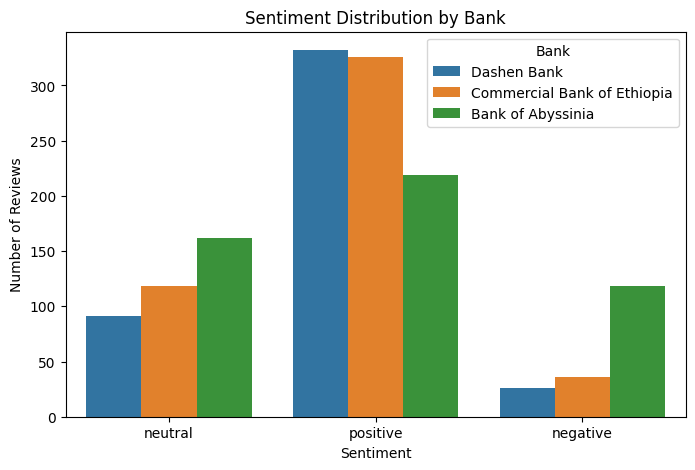

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', hue='bank')
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.legend(title="Bank")
plt.show()